---
title: Overview of the event
---

We are using `PSP_SWP_SPI_SF00_L3_MOM` dataset

DSCOVR_H1_FC/Np outside of its definition range <DateTimeRange: 2016-06-03T00:00:00+00:00 -> 2019-06-27T23:58:59+00:00>

In [ ]:
# | echo: false
# | output: false
from sunpy.time import TimeRange
from space_analysis.utils.speasy import Variables

from space_analysis.plasma.formulary import df_beta, df_Alfven_speed
from space_analysis.utils.basic import resample

import polars as pl
from beforerr.polars import pl_norm

from functools import partial
import astropy.units as u
from astropy.constants import m_p

from datetime import timedelta

import hvplot.polars  # noqa
import matplotlib.pyplot as plt

In [186]:
# hvplot.extension('bokeh', 'matplotlib')
# hvplot.output(backend='matplotlib', fig='svg')

In [187]:
psp_dataset = "PSP_SWP_SPI_SF00_L3_MOM"
psp_parameters = ["DENS", "VEL_RTN_SUN", "TEMP", "MAGF_SC", "SUN_DIST"]

In [188]:
# Encounter 2
psp_start = "2019-04-07T01:00"
psp_end = "2019-04-07T09:00"

earth_start = "2019-04-09"
earth_end = "2019-04-14"

every = timedelta(minutes=4)

mission = "Wind"
# mission = "DSCOVR"

fname = f"../figures/evolution/plasma-adiabatic-evolution_e2-{mission}"

In [189]:
# # Encounter 4
# psp_start = '2020-01-27'
# psp_end = '2020-01-29'

# earth_start = '2020-01-29'
# earth_end = '2020-01-31'

# every = timedelta(minutes=4)

# mission = 'Wind'

# fname = f"../figures/evolution/plasma-adiabatic-evolution_e4-{mission}"

In [190]:
psp_timerange = TimeRange(psp_start, psp_end)

earth_timerange = TimeRange(earth_start, earth_end)

In [191]:
match mission.lower():
    case "dscovr":
        e_mag_dataset = "DSCOVR_H0_MAG"
        e_mag_parameters = ["B1F1"]
        e_plasma_dataset = "DSCOVR_H1_FC"
        e_plasma_parameters = ["Np", "V_GSE", "THERMAL_TEMP"]
    case "wind":
        e_mag_dataset = "WI_K0_MFI"
        e_mag_parameters = ["BF1"]
        e_plasma_dataset = "WI_K0_SWE"
        e_plasma_parameters = ["Np", "V_GSM", "THERMAL_SPD"]

In [192]:
def validate(timerange):
    if isinstance(timerange, TimeRange):
        return [timerange.start.to_string(), timerange.end.to_string()]

In [193]:
psp_plasma_vars = Variables(
    dataset=psp_dataset, parameters=psp_parameters, timerange=validate(psp_timerange)
).retrieve_data()

vec_cols = psp_plasma_vars.data[1].columns
psp_mag_cols = psp_plasma_vars.data[3].columns

In [194]:
def preview(products: list[str]):
    vars = Variables(
        products=products, timerange=validate(earth_timerange)
    ).retrieve_data()

    fig, axes = plt.subplots(2)
    vars.data[0].replace_fillval_by_nan().plot(ax=axes[0])
    vars.data[1].replace_fillval_by_nan().plot(ax=axes[1])

    return fig, axes


# preview(["cda/DSCOVR_H1_FC/THERMAL_TEMP", "cda/WI_K0_SWE/THERMAL_SPD"])
# preview(["cda/DSCOVR_H0_MAG/B1F1", "cda/WI_K0_MFI/BF1"])

In [195]:
vars = Variables(
    products=["cda/DSCOVR_H1_FC/THERMAL_TEMP", "cda/WI_K0_SWE/THERMAL_SPD"],
    timerange=validate(earth_timerange),
).retrieve_data()

#### Check Different Density Product 

Time resolution (from high to low): SPC, SPI, SQTN, QTN
Quality (fluctuating, from high to low): SQTN, QTN, SPC/SPI

So we use `SQTN` dataset for density variables.

In [ ]:
from space_analysis.utils.speasy import Variables, Variable

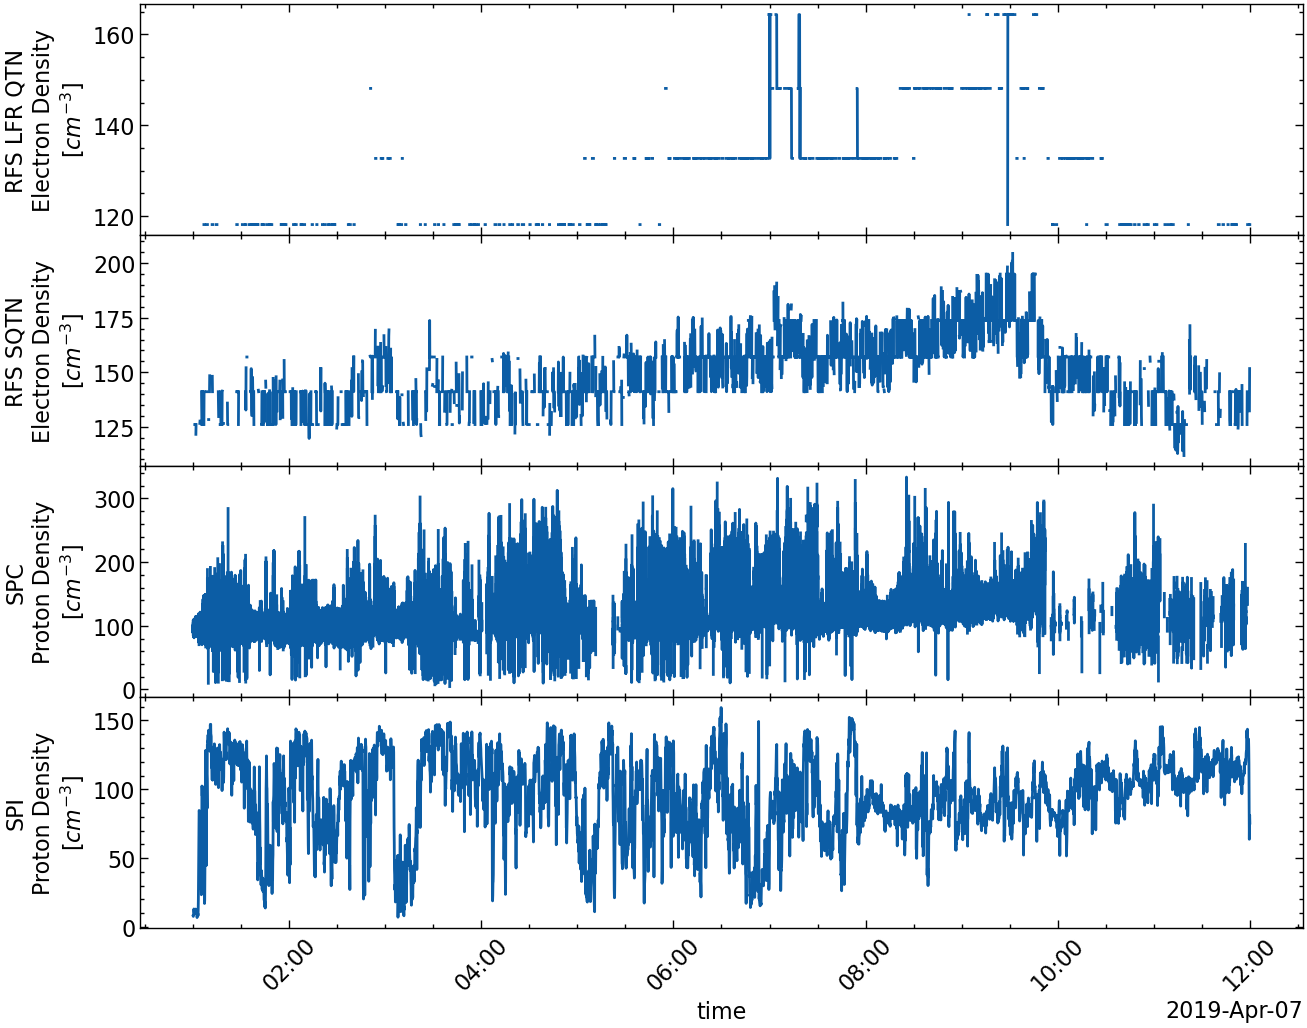

In [ ]:
vs = Variables(
    timerange=psp_timerange,
    variables=[
        Variable(
            product="cda/PSP_FLD_L3_RFS_LFR_QTN/N_elec",
            name="RFS LFR QTN\nElectron Density\n[$cm^{{-3}}$]",
        ),
        Variable(
            product="cda/PSP_FLD_L3_SQTN_RFS_V1V2/electron_density",
            name="RFS SQTN\nElectron Density\n[$cm^{{-3}}$]",
        ),
        Variable(
            product="cda/PSP_SWP_SPC_L3I/np_moment_gd",
            name="SPC\nProton Density\n[$cm^{{-3}}$]",
        ),
        Variable(
            product="cda/PSP_SWP_SPI_SF00_L3_MOM/DENS",
            name="SPI\nProton Density\n[$cm^{{-3}}$]",
        ),
    ],
)

fig, axes = vs.plot()
fig.set_size_inches(15, 12)
# remove legend from all
for ax in axes:
    ax.get_legend().remove()

fig.savefig(
    "../figures/examples/psp_density_comparison.png", bbox_inches="tight", dpi=300
)

In [ ]:
from speasy import get_data, SpeasyVariable

## Radial evolution of the coronal hole high-speed streams

@perroneRadialEvolutionSolar2019 used HELIOS observations to study the radial evolution of the solar wind in coronal hole high-speed streams. They found that The radial dependence of the proton number density, np, and the magnetic field, B, is given by

The radial dependence of the proton number density, np is

$$n_p = (2.4 ± 0.1)(R/R_0)^{−(1.96±0.07)} cm^{−3}$$

$$B = (5.7 ± 0.2)(R/R_0)^{−(1.59±0.06)} nT$$

The faster decrease of the magnetic than kinetic pressure is reﬂected in the radial proton plasma beta variation

$$β_p = P_k/P_B = (0.55 ± 0.04)(R/R_0)^{(0.4±0.1)}.$$

The behaviour of the parallel proton plasma beta is similar 

$$β_{‖} = (0.37 ± 0.03)(R/R_0)^{(0.8±0.1)}$$

In [196]:
def plasma_r_evolution(
    df: pl.DataFrame,
    alpha_beta_r=0.4,
    alpha_beta_parallel_r=0.9,
    alpha_n=-2,
    alpha_B=-1.63,
    alpha_plasma_speed=0,
):
    return df.with_columns(
        plasma_speed_1AU=pl.col("plasma_speed")
        * (1 / pl.col("distance2sun")) ** alpha_plasma_speed,
        n_1AU=pl.col("n") * (1 / pl.col("distance2sun")) ** alpha_n,
        B_1AU=pl.col("B") * (1 / pl.col("distance2sun")) ** alpha_B,
        beta_1AU=pl.col("beta") * (1 / pl.col("distance2sun")) ** alpha_beta_r,
        beta_parallel=pl.col("beta")
        * (1 / pl.col("distance2sun")) ** alpha_beta_parallel_r,
    )

In [197]:
km2au = u.km.to(u.AU)

In [198]:
psp_plasma_r = (
    psp_plasma_vars.to_polars()
    .pipe(resample, every)
    .with_columns(
        B=pl_norm(psp_mag_cols),
        plasma_speed=pl_norm(vec_cols),
        distance2sun=pl.col("Sun Distance") * km2au,
    )
    .rename(
        {
            "Density": "n",
            "Temperature": "T",
        }
    )
    .collect()
    .pipe(df_beta)
    .pipe(plasma_r_evolution)
    .pipe(df_Alfven_speed)
    .pipe(df_Alfven_speed, B="B_1AU", n="n_1AU", col_name="Alfven_speed_1AU")
    .with_columns(
        plasma_speed_over_Alfven_speed=pl.col("plasma_speed") / pl.col("Alfven_speed"),
        plasma_speed_over_Alfven_speed_1AU=pl.col("plasma_speed_1AU")
        / pl.col("Alfven_speed_1AU"),
    )
)

In [199]:
def thermal_spd2temp(speed, speed_unit=u.km / u.s):
    return (m_p * (speed * speed_unit) ** 2 / 2).to("eV").value


def df_thermal_spd2temp(
    ldf: pl.LazyFrame,
    speed_col,
    speed_unit=u.km / u.s,
    name="plasma_temperature",
    temp_unit=u.eV,
):
    df = ldf.collect()
    temp = thermal_spd2temp(df[speed_col].to_numpy(), speed_unit)
    return df.with_columns(pl.Series(temp).alias(name)).lazy()

In [200]:
def process(
    timerange,
    mag_dataset: str,
    mag_parameters: list[str],
    plasma_dataset: str,
    plasma_parameters: list[str],
):
    timerange = validate(timerange)

    mag_vars = Variables(
        dataset=mag_dataset,
        parameters=mag_parameters,
        timerange=timerange,
    ).retrieve_data()

    plasma_vars = Variables(
        dataset=plasma_dataset,
        parameters=plasma_parameters,
        timerange=timerange,
    ).retrieve_data()

    temp_vars = plasma_vars.data[2]

    density_col = plasma_vars.data[0].columns[0]
    vec_cols = plasma_vars.data[1].columns
    temp_col = temp_vars.columns[0]
    mag_col = mag_vars.data[0].columns[0]

    plasma_data = (
        plasma_vars.to_polars()
        .with_columns(plasma_speed=pl_norm(vec_cols))
        .rename({density_col: "n"})
    ).pipe(resample, every)
    # process temperature data

    if temp_vars.unit == "km/s":
        plasma_data = plasma_data.pipe(df_thermal_spd2temp, temp_col, name="T")
        T_unit = u.eV
    else:
        plasma_data = plasma_data.rename({temp_col: "T"})
        if temp_vars.unit.startswith("K"):
            T_unit = u.K

    mag_data = mag_vars.to_polars().pipe(resample, every).rename({mag_col: "B"})

    df = (
        plasma_data.sort("time")
        .join_asof(mag_data.sort("time"), on="time")
        .collect()
        .pipe(df_beta, T_unit=T_unit)
        .pipe(df_Alfven_speed)
        .with_columns(
            plasma_speed_over_Alfven_speed=pl.col("plasma_speed")
            / pl.col("Alfven_speed"),
        )
    )
    return df

In [201]:
from copy import deepcopy

In [202]:
func = partial(
    process,
    mag_dataset=e_mag_dataset,
    mag_parameters=e_mag_parameters,
    plasma_dataset=e_plasma_dataset,
    plasma_parameters=e_plasma_parameters,
)

In [203]:
e_df_previous = func(deepcopy(earth_timerange).previous())
e_df = func(earth_timerange)
e_df_next = func(deepcopy(earth_timerange).next())

In [204]:
plot = psp_plasma_r.plot(
    x="time",
    y=["plasma_speed", "beta", "Alfven_speed", "plasma_speed_over_Alfven_speed"],
    subplots=True,
    shared_axes=False,
).cols(1)

plot_1AU = psp_plasma_r.plot(
    x="time",
    y=[
        "plasma_speed_1AU",
        "beta_1AU",
        "Alfven_speed_1AU",
        "plasma_speed_over_Alfven_speed_1AU",
    ],
    subplots=True,
    shared_axes=False,
).cols(1)

plot + plot_1AU

Cannot render NdLayout nested inside a Layout

:Layout
   .NdLayout.I  :NdLayout   [Variable]
      :Curve   [time]   (value)
   .NdLayout.II :NdLayout   [Variable]
      :Curve   [time]   (value)

In [205]:
def compare_df(df1, df2):
    df1_plot = df1.plot.scatter(
        x="beta", y="plasma_speed_over_Alfven_speed", label="PSP"
    ) * df1.plot.scatter(
        x="beta_1AU",
        y="plasma_speed_over_Alfven_speed_1AU",
        label="PSP (1AU predicted)",
    )

    df2_plot = df2.plot.scatter(
        x="beta",
        y="plasma_speed_over_Alfven_speed",
        label=mission,
        alpha=0.2,
    )

    xlabel = "Plasma beta"
    # ylabel=r"$v_i$ / $v_A$"
    ylabel = "Plasma speed over Alfven speed"

    return (df2_plot * df1_plot).opts(
        xlabel=xlabel, ylabel=ylabel, logx=True, logy=True
    )

In [ ]:
hvplot.extension("bokeh", "matplotlib")
hvplot.output(backend="matplotlib", fig="svg")

In [207]:
fig = compare_df(psp_plasma_r, e_df_previous).opts(title="Previous Period")
hvplot.save(fig, fname + "-previous", fmt="svg")
# hvplot.save(fig, fname + "-previous.svg")

In [208]:
fig = compare_df(psp_plasma_r, e_df).opts(title="Current Period")
hvplot.save(fig, fname, fmt="svg")

In [209]:
fig = compare_df(psp_plasma_r, e_df_next).opts(title="Next Period")
hvplot.save(fig, fname + "-next", fmt="svg")